# Hybrid Image Generation with Neural Style Transfer

In this notebook, we will explore the process of hybrid image generation using neural style transfer. The notebook covers the following key steps:

1. **Preprocessing**: We will begin by preparing the content and style images for neural network input, including resizing, normalization, and transforming the images into a format suitable for PyTorch models.
2. **Feature Extraction**: Using a pre-trained VGG19 model, we will extract the features from both the content and style images.
3. **Loss Calculation**: We will compute the content and style loss functions, which measure how well the generated image matches the content and style of the input images.
4. **Image Optimization**: Using the calculated losses, we will optimize the generated image to gradually blend the content and style features.
5. **Postprocessing**: The final generated image will undergo postprocessing steps, such as de-normalization and dimension adjustments, to make it suitable for display.

The aim is to create a hybrid image that combines the content of one image with the artistic style of another, demonstrating the power of neural networks in artistic image transformation.

In [10]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy
import os
import requests
import time
import pandas
pandas.set_option('display.max_colwidth', 0)

from IPython import display
import matplotlib.pyplot as plt
from io import BytesIO
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
import torchvision.models as models
from torchvision import transforms
from tqdm import tqdm

from PIL import Image

**Constants and Variables**

In [11]:
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406] # Mean for each color channel
IMAGENET_STD = [0.229, 0.224, 0.225]  # Std for each color channel
STYLE_IMAGE = 'style_image'
CONTENT_IMAGE = 'content_image'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

results = {'Name':[],
           'Shape':[],
           'Mean':[],
           'Std':[],
          }

**Image Fetching, Feature Extraction, and Gram Matrix Calculation**

In [12]:
def fetch_image(file_id):
    """
    This function downloads an image you share from your Google Drive.
    It returns the image in a PIL format.
    """
    URL = "https://drive.google.com/uc?"
    session = requests.Session()
    
    r = session.get(URL, params = { 'id' : file_id, 'alt' : 'media'}, stream = True)
    error_msg = f'ERROR: impossible to download the image (code={r.status_code})'
    assert(r.status_code == 200), error_msg
    
    params = { 'id' : file_id, 'confirm' : 'download_warning' }
    r = session.get(URL, params = params, stream = True)
    stream = BytesIO(r.content)
    image = Image.open(stream)
    return image
    
# Gram matrix
def gram_matrix(tensor):
    """
    Calculation of the Gram matrix for a given tensor.
    Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # Get the (B, C, H, W) of the Tensor
    _, d, h, w = tensor.size()
    
    # Reshape tensor to multiply the features for each channel
    tensor = tensor.view(d, h * w)
    
    # Calculate the Gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

def extract_features(image, model_features, layers=None):
    """
    Infers the image into the model and extracts the features for
    the desired layers. The default layers are consistent with
    those of the VGG19 network of Gatys et al. (2016).
    """
    if layers is None:
        layers = {'0': 'conv1_1',
                  '2': 'conv1_2',
                  '5': 'conv2_1',
                  '7': 'conv2_2',
                  '10': 'conv3_1',
                  '12': 'conv3_2',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1',
                  '30': 'conv5_2'}
                
    features = {}
    x = image
    for layer_idx, layer in enumerate(model_features):
        x = layer(x)
        if str(layer_idx) in layers:
            features[layers[str(layer_idx)]] = x
            
    return features 

**Image Download and Display (Style and Content Images)**

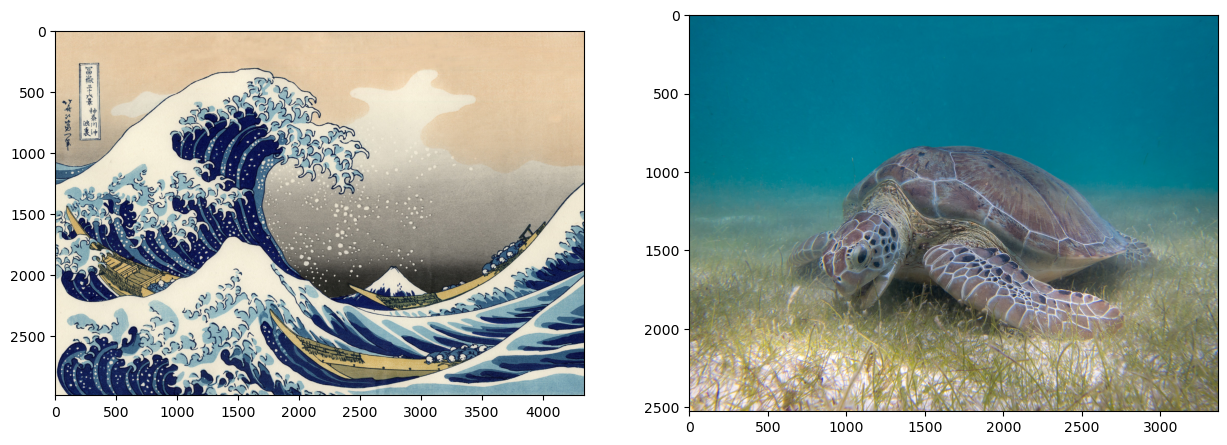

In [13]:
# Download an image containing the style to extract
style_image_file_id = "1-xPNgqRtKNscyEk4_0yZfDcC7elhp7dD"
style_image = fetch_image(style_image_file_id)

# Download an image on which to apply the style
content_image_file_id = "1t-7DShyE36ik3XklOiMb8Xd4bqFt_h6y"
content_image = fetch_image(content_image_file_id)

images = {STYLE_IMAGE:style_image,
          CONTENT_IMAGE:content_image}

# Display the 2 images side by side
plt.figure(figsize=(15,15))

# Displaying the image_style
plt.subplot(1, 2, 1)
plt.imshow(images[STYLE_IMAGE])

# Displaying the content_image
plt.subplot(1, 2, 2)
plt.imshow(images[CONTENT_IMAGE])

**Custom Image Preprocessing and Postprocessing**

In [14]:
# Custom transformation class to add a channel at the "dim" position.
class AddDimension(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, x):
        """
        Args:
            tensor (Tensor): Tensor image of size (C,H,W).

        Returns:
            tensor (Tensor): Tensor image with an added channel, now of size (1,C,H,W).
        """
        new_x = x.unsqueeze(self.dim)

        return new_x
    
# Preprocessing steps
# 1. Resize the image to the desired size -> (3, 256, 256)
# 2. Transform the PIL image into a tensor
# 3. Apply ImageNet normalization
# 4. Add a dimension for PyTorch (C,H,W) -> (B,C,H,W)
# where B is the batch size.
preprocessing = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=IMAGENET_MEAN,
                                                         std=IMAGENET_STD),
                                    AddDimension(0),
                                   ])
 
# Since PyTorch works on batches of images,
# an extra dimension (B) is added for its operation. The input
# image goes from the size (3, 256, 256) to the size
# (B, 3, 256, 256) where B, here, is of size 1, because
# there is only one image per batch.

# However, in order to display the hybrid image, it is important
# to remove this extra dimension, because the display tools
# expect to display a single image. 
# This next class should allow you to 
# remove this extra dimension.

class RemoveDimension(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, x):
        """
        Args:
            x (Tensor): Tensor image of size (1,C,H,W).

        Returns:
            new_x (Tensor): Tensor image with the removed channel, now of size (C,H,W).
        """
        
        new_x = torch.squeeze(x, self.dim)
        
        return new_x
    
# As the VGG19 network has been pre-trained on ImageNet
# with specific normalization parameters for this dataset, 
# it is assumed that it will perform better on a new
# image distribution if it shares this normalization. Thus, for the extraction
# of style and content features, the VGG19 model must
# work on normalized images.
#
# However, in order to display the hybrid image, it is
# important to remove the normalization 
# to get a visually interesting result,
# because normalization has an impact on the distribution
# of pixel values in the image.

class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)  

    def __call__(self, x):
        """
        Args:
            x (Tensor): Tensor image of shape (C,H,W).
        Returns:
            new_x (Tensor): DeNormalized tensor image (C,H,W).
        """

        # Implementation of a custom transformation 
        # to apply the inverse normalization.

        # invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
        #                                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        #                     transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
        #                                         std = [ 1., 1., 1. ]),
        #                 ])
        #new_x = invTrans(x)

        new_x = x * self.std + self.mean
        
        return new_x # Retourne le x transformé / return the transformed x

# For the images to be displayed, the pixel value must be between [0,1].
# The following class should allow you to bound
# the pixel values of the hybrid image between [0,1].
class Clamp(object):
    def __init__(self, min, max):
        self.min = float(min)
        self.max = float(max)

    def __call__(self, x):
        """
        Args:
            x (Tensor): Tensor of the image.

        Returns:
            new_x (Tensor): Tensor with values clipped within [0,1].
        """

        new_x = torch.clamp(x, min=self.min, max=self.max)
        
        return new_x

# In order for the Matplotlib library to display the
# content of the images, the channels must
# be given in the right order. PyTorch uses images in the form
# (B,C,H,W) and Matplotlib must receive the images under 
# the form (H,W,C). As the Permute is called after the
# RemoveDimension(), you will have here, as input, a tensor
# (C,H,W) that you must transform into the
# desired form for the display of Matplotlib.
class Permute(object):
    def __init__(self, dims):
        self.dims = dims

    def __call__(self, x):
        """
        Args:
            x (Tensor): Tensor of the image.

        Returns:
            new_x (Tensor): Tensor of the image with permuted dimensions.
        """
        
        new_x = torch.permute(x, self.dims)
        
        return new_x

# 1. Remove the 1st dimension (B,C,H,W)->(C,H,W)
# 2. Apply the inverse of the ImageNet normalization
# 3. Swap dimensions for Matplotlib (C,H,W)->(H,W,C)
# 4. Clamp the tensor values between [0,1]
postprocessing = transforms.Compose([RemoveDimension(0), 
                                     DeNormalize(mean=IMAGENET_MEAN,
                                                 std=IMAGENET_STD),
                                     Permute((1, 2, 0)),
                                     Clamp(0,1),
                                    ])

**Displaying and Verifying Image Statistics During Preprocessing and Postprocessing**

In [15]:
# The following code is given to allow to display
# some useful information that will allow us to
# understand if our postprocessing transformations
# are functional.

# Display the statistics of natural images
for name, img in images.items():
    results['Name'].append(f'raw_{name}')
    results['Shape'].append(img.size)
    mean = numpy.mean(img)/255
    results['Mean'].append(mean)
    std = numpy.std(img)/255
    results['Std'].append(std)

# Apply preprocessing on the images
pre_images = {}
for k,v in images.items():
    pre_images[k] = preprocessing(v)
    pre_images[k] = pre_images[k].to(DEVICE)

# Display the statistics of the transformed images
for name, img in pre_images.items():
    results['Name'].append(f'pre_{name}')
    results['Shape'].append(img.shape)
    results['Mean'].append(img.mean().item())
    results['Std'].append(img.std().item())

post_images = {}

# Apply postprocessing to images
for name,img in pre_images.items():
    image = img.cpu().detach()
    post_images[name] = postprocessing(image)

# Display the statistics of the transformed images
for name, img in post_images.items():
    results['Name'].append(f'post_{name}')
    results['Shape'].append(img.shape)
    results['Mean'].append(img.mean().item())
    results['Std'].append(img.std().item())

# N.B. Although the size of the image has been changed by the resize,
# the mean and standard deviation values should be very close
# before preprocessing and after postprocessing.
df = pandas.DataFrame(results)
display.display(df)

Name             Shape      Mean       Std
0  raw_style_image     (4335, 2990)      0.625157  0.272809
1  raw_content_image   (3367, 2525)      0.433863  0.212015
2  pre_style_image     (1, 3, 256, 256)  0.780130  1.073071
3  pre_content_image   (1, 3, 256, 256) -0.062936  0.963563
4  post_style_image    (256, 256, 3)     0.625152  0.242552
5  post_content_image  (256, 256, 3)     0.433717  0.205784

**Load and Freeze VGG19 Features for Neural Style Transfer**

In [17]:
# Download the features portion of the VGG19
# We don't need the classification layers.
# Pre-trained layers are freezed
# ******

model = models.vgg19(pretrained=True, progress=False)
vgg = model.features

for name, param in vgg.named_parameters():
    print(name)
    print(param.grad)
    
for name, param in vgg.named_parameters():
    param.requires_grad = False
    
vgg.to(DEVICE)


/Users/younismbs/anaconda3/envs/myEmv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/younismbs/anaconda3/envs/myEmv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.weight
None
0.bias
None
2.weight
None
2.bias
None
5.weight
None
5.bias
None
7.weight
None
7.bias
None
10.weight
None
10.bias
None
12.weight
None
12.bias
None
14.weight
None
14.bias
None
16.weight
None
16.bias
None
19.weight
None
19.bias
None
21.weight
None
21.bias
None
23.weight
None
23.bias
None
25.weight
None
25.bias
None
28.weight
None
28.bias
None
30.weight
None
30.bias
None
32.weight
None
32.bias
None
34.weight
None
34.bias
None


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

**Setup and Feature Extraction for Neural Style Transfer**

In [18]:
if not(torch.cuda.is_available()): 
    print("You have no GPU !!!")

# Extract the features of the style image with the function
# extract_features.

tensor_style = pre_images['style_image'].to(DEVICE)

style_features = extract_features(tensor_style, vgg)

# Extract the features of the content image with the function
# extract_features.

tensor_content = pre_images['content_image'].to(DEVICE)

content_features = extract_features(tensor_content, vgg)

# Pre-compute the Gram matrix for each style layer
style_grams = {}
for layer in style_features:
    style_grams[layer] = gram_matrix(style_features[layer])

# Create a temporary target image

target = tensor_content.clone().to(DEVICE)
target.requires_grad = True

# Poids appliqués pour chaque couche de style
# Weights applied for each style layer 
# Valeurs par défaut / default values:
# 'conv1_1': 1.
# 'conv2_1': 0.75
# 'conv3_1': 0.2
# 'conv4_1': 0.2
# 'conv5_1': 0.2
style_layers_weights = {'conv1_1': 1.,
                        'conv2_1': 0.75,
                        'conv3_1': 0.2,
                        'conv4_1': 0.2,
                        'conv5_1': 0.2}

# By default: content_weight = 1
content_weight = 1 

# By default: style_weight = 1e7
style_weight = 1e7

You have no GPU !!!


**Implementation of Content and Style Loss Calculation for Neural Style Transfer**

 10%|▉         | 499/5000 [02:48<25:12,  2.98it/s]

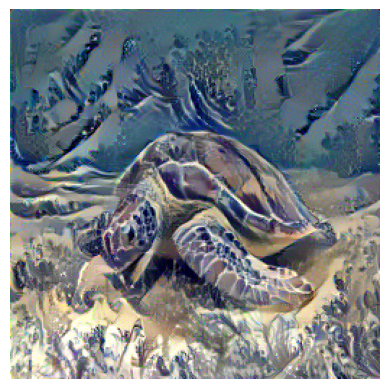

 20%|█▉        | 999/5000 [05:36<22:06,  3.02it/s]

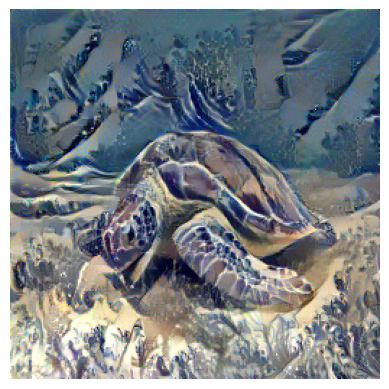

 30%|██▉       | 1499/5000 [08:23<19:36,  2.98it/s]

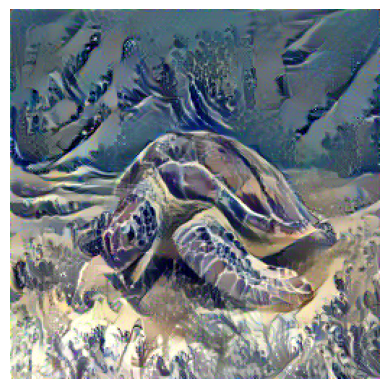

 40%|███▉      | 1999/5000 [11:11<16:36,  3.01it/s]

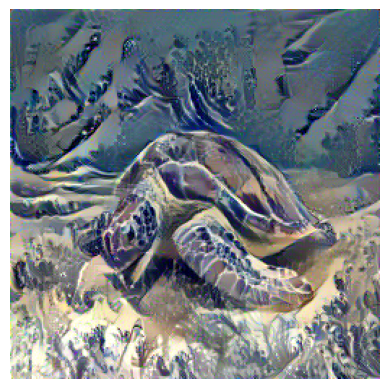

 50%|████▉     | 2499/5000 [14:00<14:02,  2.97it/s]

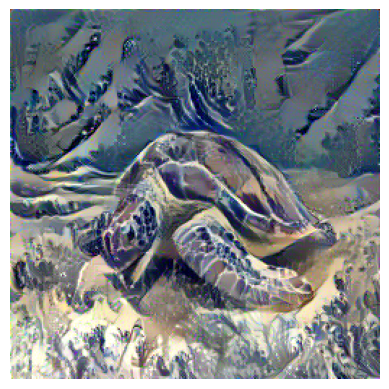

 60%|█████▉    | 2999/5000 [16:48<11:11,  2.98it/s]

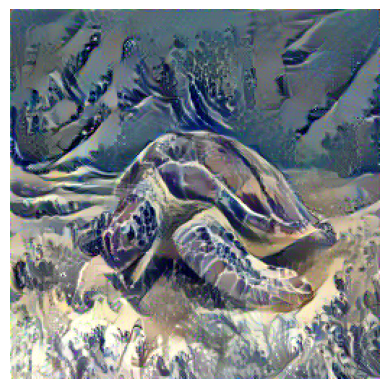

 70%|██████▉   | 3499/5000 [19:36<08:22,  2.98it/s]

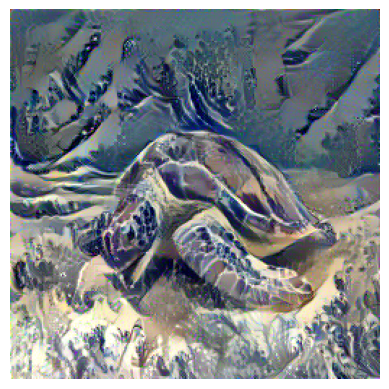

 80%|███████▉  | 3999/5000 [22:25<05:35,  2.99it/s]

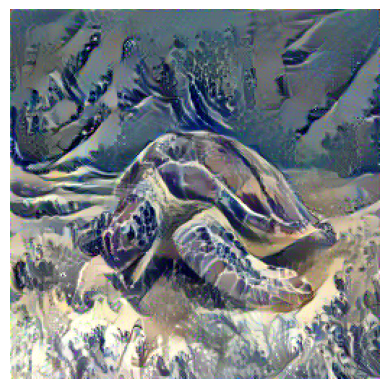

 90%|████████▉ | 4499/5000 [41:28<02:47,  2.99it/s]    

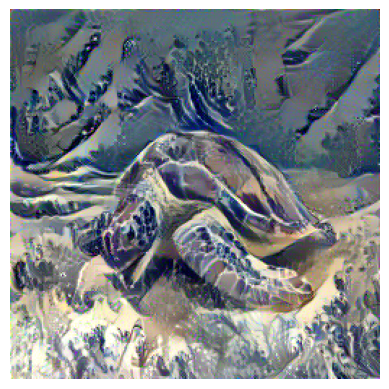

100%|█████████▉| 4999/5000 [44:16<00:00,  2.99it/s]

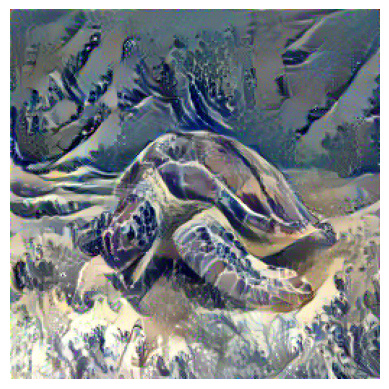

100%|██████████| 5000/5000 [44:16<00:00,  1.88it/s]


In [130]:
# Implementation of the function that calculates the content loss for
# a given layer. The loss is calculated as the squared error
# between the parameters of the target image and the parameters
# of the content image for each layer.

def calculate_content_loss(layer_name):
    assert(layer_name in target_features.keys())
    assert(layer_name in content_features.keys())
    """
    Calculates the content loss between the target image features and
    the content image features.

    Args:
        layer_name (String) : Name of the layer to evaluate.

    Returns:
        tensor (Tensor): Tensor containing the loss of the squared mean
                         difference between the target and content layers.
    """
    F = target_features[layer_name]
    P = content_features[layer_name]
    
    content_loss = 1/2 * torch.sum( torch.pow(F - P, 2) )
    
    return content_loss

# Implementation of the function that calculates the style loss for a given layer.
# This style loss is calculated as the error between the content Gram
# matrix and the style Gram matrix, weighted by the weight given to each layer.
def calculate_style_loss(weight_layer, target_gram, style_gram, target_feature):
    """
    Calculates the style loss between the Gram matrix of the image features and
    the Gram matrix of the style image features.

    Args:
        weight_layer (Float): Weighting for the current layer (w_l).
        target_gram (Tensor): Gram matrix of the target image (G).
        style_gram (Tensor): Gram matrix of the style image (A).
        target_feature (Tensor): Tensor containing the target features for
                                 the current layer.

    Returns:
        style_loss (Tensor): Tensor with the computed style loss for the current layer.
    """
    # Get the dimensions of the target feature map
    _, N, H, W = target_feature.shape  # Batch size (ignored), number of filters (N), height (H), width (W)
    M = H * W  # Total number of spatial locations

    # Compute the squared Frobenius norm between the Gram matrices
    gram_diff = target_gram - style_gram
    loss = torch.sum(torch.pow(gram_diff, 2))  # Element-wise square and sum

    # Normalize by the layer-specific constants
    normalized_loss = loss / (4 * (N ** 2) * (M ** 2))

    # Weight by the layer weight
    style_loss = weight_layer * normalized_loss

    return style_loss

# Implementation of the function that calculates the total loss for the iteration.
# The total loss is calculated by the weighted sum of the content loss
# and the style loss.
def calculate_total_loss(content_weight, content_loss, style_weight, style_loss):
    """
    Calculates the total loss for the current iteration.

    Args:
        content_weight (Float) : Alpha weighting for the content.
        content_loss (Float) : Content loss.
        style_weight (Float) : Beta weighting for the style.
        style_loss (Float) : Total loss.

    Returns:
        total_loss (Tensor): Tensor with the computed total loss for the current iteration. 
    """
    
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    return total_loss

# Total number of iterations to apply
# style transfer (Min: 2000 | Recommended: 5000)
steps = 5000

# Image update frequency (Recommended value: 500)
show_image_every = 500

# Initialization of the Adam optimizer. Since we modify the target,
# we apply it directly on the pixels of the image (learning_rate = 3e-3).
#
# [Gatys et al, 2016] make use of L-BFGS but to simplify implementation and accelerate
# convergence to visible results, Adam is more appropriate.

optimizer = optim.Adam([target], lr=3e-3)

for s in tqdm(range(1, steps+1)):

    # 1. Reset the gradients to zero
    optimizer.zero_grad()
    
    # 2. Extract the features of the target image
    target_features = extract_features(target, vgg)
    
    # 3. Calculate the content loss with the function
    # calculate_content_loss. You must find the
    # name of the layer in the model graph.
    layer_name = "conv4_2"
    content_loss = calculate_content_loss(layer_name)

    # 4. Calculate the style loss by accumulating its value for each layer
    style_loss = 0 # Initialiser la loss de style à zéro / Initialise style loss to zero
    for l_name, l_weight in style_layers_weights.items():
        
        # Extraire le contenu de la couche / Extract layer content
        target_feature = target_features[l_name]

        # Calculer la matrice de Gram du contenu / Compute content Gram matrix
        target_gram = gram_matrix(target_feature)

        # Extraire la matrice Gram pré-calculée pour le style
        # Extract the pre-computed Gram matrix for the style
        style_gram = style_grams[l_name]

        # Calculate the weighted syle loss for 
        # the given layer with the function calculate_style_loss().
        layer_style_loss = calculate_style_loss(l_weight,
                                                target_gram,
                                                style_gram,
                                                target_feature)

        # Accumuler la loss de style / Accumulate style loss
        style_loss += layer_style_loss
    
    # 5. Calculate the total loss with the function calculate_total_loss()
    total_loss = calculate_total_loss(content_weight,
                                      content_loss,
                                      style_weight,
                                      style_loss)
    
    # 6. Update the target image
    total_loss.backward()
    optimizer.step()
    
    # Afficher les images intermédiaires
    # Display intermediate images
    if  s % show_image_every == 0:
        # Appliquer le postprocessing sur les images
        # Apply postprocessing to the images
        plt.figure()
        img = target.cpu().detach()
        img_post = postprocessing(img)
        plt.imshow(img_post)
        plt.axis('off')
        plt.show()

# Free the cache on the GPU
torch.cuda.empty_cache()